In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco

flanksize=20

onehot_data = np.load('extracted_onehot.npy')[:,:]
hypothetical_data = np.load('extracted_hypothetical_scores.npy')[:,:]
contrib_data = np.load('extracted_contrib_scores.npy')[:,:]

contrib_scores_track = modisco.core.DataTrack(name="contrib_scores",
                                 fwd_tracks=contrib_data,
                                 rev_tracks=contrib_data[:,::-1, ::-1])
hypcontrib_scores_track = modisco.core.DataTrack(name="hypcontrib_scores",
                                    fwd_tracks=hypothetical_data,
                                    rev_tracks=hypothetical_data[:,::-1, ::-1])
onehot_track = modisco.core.DataTrack(name="onehot",
                         fwd_tracks=onehot_data,
                         rev_tracks=onehot_data[:,::-1, ::-1])
track_set = modisco.core.DataTrackSet(data_tracks=[
                contrib_scores_track, hypcontrib_scores_track, onehot_track])

coords = []
perposimp = np.sum(contrib_data,axis=-1)[:,50:50+41]
for example_idx in range(len(onehot_data)):
    #figure out the 6bp window with highest imp
    padded_cumsum = np.array([0]+list(np.cumsum(perposimp[example_idx])))
    sliding_window_imp = padded_cumsum[7:] - padded_cumsum[:-7]
    start = np.argmax(sliding_window_imp)+50
    coords.append(modisco.core.Coordinate(
                    example_idx=example_idx, start=start-17,
                    end=start+24, is_revcomp=False))

all_seqlets = [x for x in track_set.create_seqlets(coords=coords, flanks=flanksize) if np.sum(x["contrib_scores"].corefwd) > 0]

/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [235]:
len(all_seqlets)

98183

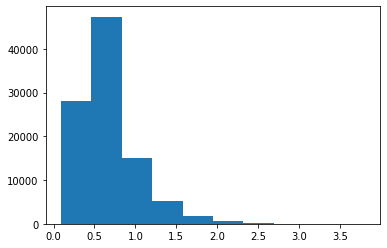

In [3]:
from matplotlib import pyplot as plt
plt.hist([np.sum(x["contrib_scores"].corefwd) for x in all_seqlets])
plt.show()

In [4]:
seqlets_subsample = [all_seqlets[i] for i in np.random.RandomState(1).choice(
                                              np.arange(len(all_seqlets)), size=5000,replace=False)]

In [5]:
len(seqlets_subsample)

5000

In [12]:
import modisco.affinitymat
reload(modisco.affinitymat)
import modisco.util
reload(modisco.util)
import gc
gc.collect()

min_overlap_frac=0.75

affmat_computer = modisco.affinitymat.SequenceAffmatComputer_Impute(
                    metric=modisco.util.l1norm_contin_jaccard_sim,
                    n_jobs=8, min_overlap_frac=min_overlap_frac)

affmat, offsets, isfwdmat = affmat_computer(seqlets_subsample, onehot_trackname="onehot",
                                            hyp_trackname="hypcontrib_scores")

np.save("affmat_recenter_41bpseqlets_"+str(min_overlap_frac)+".npy", affmat)
np.save("offsets_recenter_41bpseqlets_"+str(min_overlap_frac)+".npy", offsets)
np.save("isfwdmat_recenter_41bpseqlets_"+str(min_overlap_frac)+".npy", isfwdmat)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   34.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:  5.7min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:  7.7min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed: 12.4min
[Parallel(n_jobs=8)]: Done 4984 tasks      | elapsed: 15.1min
[Parallel(n_jobs=8)]: Done 5000 out of 5000 | elapsed: 15.1min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   31.4s
[Parallel(n_jobs=8)]: Done 434 tasks    

In [13]:
!ls

TestNewModiscoBPNet.ipynb              isfwdmat_0.6.npy
affmat_0.6.npy                         isfwdmat_recenter_0.35.npy
affmat_recenter_0.35.npy               isfwdmat_recenter_41bpseqlets_0.75.npy
affmat_recenter_41bpseqlets_0.75.npy   offsets_0.6.npy
extracted_contrib_scores.npy           offsets_recenter_0.35.npy
extracted_hypothetical_scores.npy      offsets_recenter_41bpseqlets_0.75.npy
extracted_onehot.npy


In [40]:
affmat = np.load("affmat_recenter_41bpseqlets_0.75.npy")
offsets = np.load("offsets_recenter_41bpseqlets_0.75.npy")
isfwdmat = np.load("isfwdmat_recenter_41bpseqlets_0.75.npy")

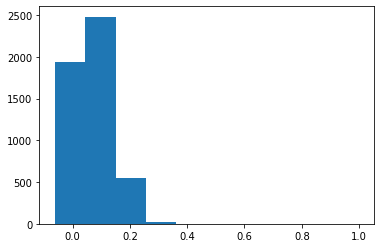

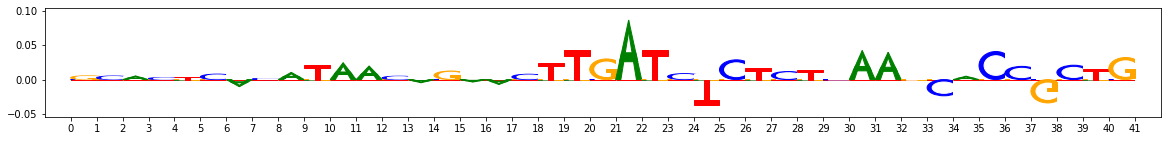

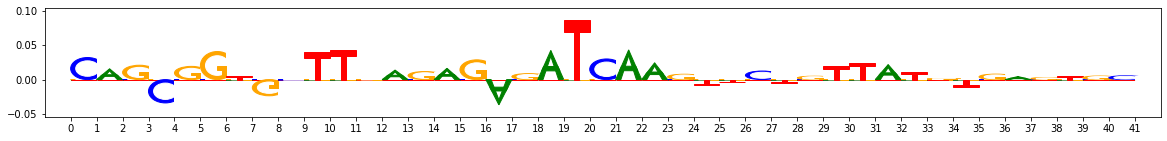

In [41]:
from modisco.visualization import viz_sequence

idx=4
plt.hist(affmat[idx])
viz_sequence.plot_weights(seqlets_subsample[idx]["contrib_scores"].corefwd)
viz_sequence.plot_weights(seqlets_subsample[idx]["contrib_scores"].corerev)
plt.show()

[t-SNE] Computing 4999 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.046s...
[t-SNE] Computed neighbors for 5000 samples in 3.152s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.274907
0.5
4.0


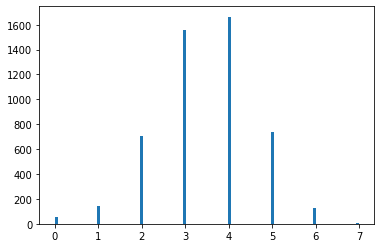

0.9
45.0


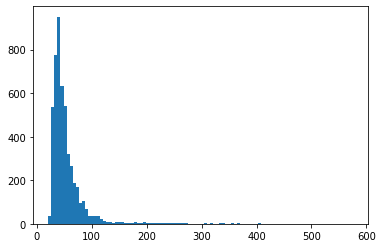

0.99
215.0


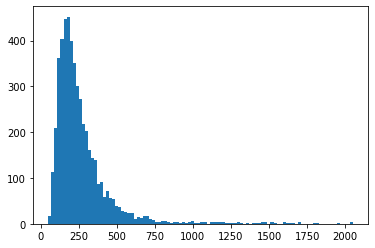

0.999
513.5


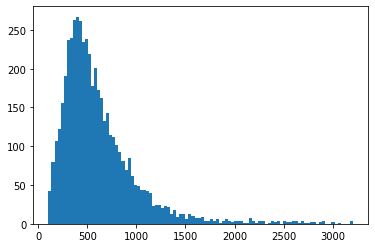

0.9999
909.0


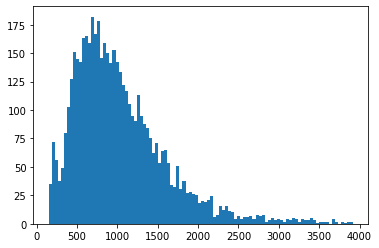

0.99999
1361.0


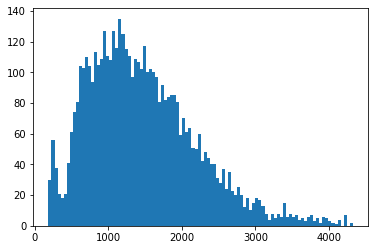

1.0
5000.0


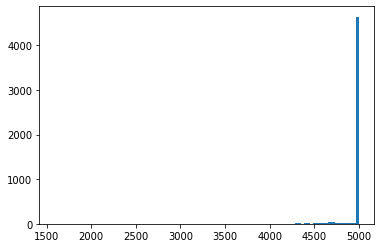

In [309]:
import modisco.core
reload(modisco.core)
import modisco.affinitymat
reload(modisco.affinitymat)

flatten = 1
distmat = np.log(1.0/(flatten*np.maximum(affmat,1e-7)) - (1.0/flatten - 1))

n_neighbors = 30
tsne_adapted = modisco.affinitymat.tsne_density_adaptation(dist_mat=distmat,
                                                           perplexity=n_neighbors)
#tsne_adapted = tsne_adapted + np.eye(len(tsne_adapted))*np.max(tsne_adapted, axis=-1)
current_affmat = (tsne_adapted*tsne_adapted.T)
#current_affmat = (tsne_adapted + tsne_adapted.T)/2.0
#make sure there is a self-similarity so there's a reason to leave things in their own cluster
currentaffmatmethod = "tsne-mulT"

#get the number of examples that contain x% of the probability density
from matplotlib import pyplot as plt

tsne_adapted_sorted_cumsum = np.cumsum(np.sort(tsne_adapted, axis=-1)[:,::-1],axis=-1)
for percent in [0.5, 0.9, 0.99, 0.999, 0.9999, 0.99999, 1.0]:
    print(percent)
    num_with_density = np.sum(tsne_adapted_sorted_cumsum <= percent, axis=-1)
    print(np.median(num_with_density))
    plt.hist(num_with_density, bins=100)
    plt.show()
    

In [211]:
nneighb_affmat = nearest_neighb_affmat(affmat=affmat, n_neighbs=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
current_affmat = nneighb_affmat*nneighb_affmat.T
currentaffmatmethod = "nneigh-mulT"

In [228]:
reload(modisco.affinitymat)
nneighb_affmat = modisco.affinitymat.nearest_neighb_affmat_expo_decay(affmat=affmat, n_neighb=50, beta=0.1)
current_affmat = nneighb_affmat*nneighb_affmat.T
currentaffmatmethod = "nneigh-expo-mulT"

In [206]:
from collections import Counter
reload(modisco.affinitymat)
from modisco.affinitymat import nearest_neighb_affmat
from modisco.affinitymat import get_diffusion_distances
import sklearn.cluster

nneighb_affmat = nearest_neighb_affmat(affmat=affmat, n_neighbs=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
dmap = np.real(modisco.affinitymat.get_concat_dmap_coords(affmat=nneighb_affmat, ts=[1],
                                                          k=int(len(nneighb_affmat)/50)))
distmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(dmap, metric='euclidean'))
current_affmat = 1.0/np.exp(distmat)
currentaffmatmethod = "nneigh-diffusionmap"

Doing eigendecomposition
Did eigendecomposition in 46.56019878387451


In [310]:
"""kmeans_clustdist = sklearn.cluster.KMeans(n_clusters=int(len(nneighb_affmat)/100),
                                          n_init=100, random_state=1234).fit_transform(dmap)
the_clustering = np.argmin(kmeans_clustdist,axis=-1)"""

print("affmat method",currentaffmatmethod)

#current_affmat = current_affmat*(1-np.eye(len(current_affmat)))

#get Leiden averaged over different seeds
averaging_rounds = 0
#keep top 5% for speed
current_affmat = current_affmat*(current_affmat>np.percentile(current_affmat.ravel(), q=95))
for round_num in range(averaging_rounds):
    current_affmat = modisco.affinitymat.average_over_different_seeds(
                        affmat=current_affmat,
                        clustering_procedure=modisco.affinitymat.LeidenClustering(
                                                partitiontype=leidenalg.ModularityVertexPartition,
                                                n_iterations=1),
                        nseeds=200)

the_clustering = modisco.affinitymat.take_best_over_different_seeds(affmat=current_affmat,
                                                clustering_procedure=modisco.affinitymat.LeidenClustering(
                                                    partitiontype=leidenalg.ModularityVertexPartition,
                                                    n_iterations=-1),
                                                nseeds=10)
print(Counter(the_clustering))

affmat method tsne-mulT


Quality: 0.917804911567565
Quality: 0.917930098232808
Quality: 0.9179580688267394

Counter({0: 345, 1: 237, 2: 225, 3: 198, 4: 186, 5: 184, 6: 182, 7: 133, 8: 107, 9: 106, 10: 104, 11: 96, 12: 92, 13: 90, 15: 86, 14: 86, 16: 85, 17: 83, 18: 81, 19: 79, 20: 78, 21: 74, 22: 70, 23: 68, 24: 66, 25: 55, 26: 54, 27: 53, 28: 53, 29: 48, 30: 48, 31: 46, 32: 46, 33: 44, 34: 43, 35: 42, 36: 41, 38: 40, 37: 40, 39: 39, 40: 38, 41: 36, 42: 34, 43: 33, 45: 31, 44: 31, 46: 30, 47: 30, 48: 29, 50: 28, 49: 28, 52: 26, 51: 26, 53: 25, 54: 24, 55: 23, 56: 22, 57: 22, 60: 21, 58: 21, 59: 21, 61: 20, 63: 19, 62: 19, 64: 18, 65: 17, 66: 17, 68: 16, 67: 16, 70: 15, 69: 15, 75: 14, 71: 14, 74: 14, 72: 14, 73: 14, 77: 12, 76: 12, 79: 11, 78: 11, 80: 10, 81: 9, 82: 9, 86: 8, 85: 8, 84: 8, 83: 8, 87: 7, 88: 7, 92: 7, 90: 7, 91: 7, 89: 7, 94: 6, 95: 6, 93: 6, 102: 5, 101: 5, 100: 5, 99: 5, 96: 5, 97: 5, 98: 5, 108: 4, 109: 4, 104: 4, 107: 4, 106: 4, 105: 4, 103: 4, 111: 3, 119: 3, 117: 3, 124: 3, 118: 3, 123: 3

In [324]:
def get_aggregated_seqlet(seqlets, in_cluster_mask, distmat, isfwdmat, offsets):
    seqletimps = np.array([np.sum(x["contrib_scores"].corefwd) for x in seqlets])
    anchor = np.argmin(np.sum(distmat[:,in_cluster_mask],axis=-1)+((in_cluster_mask==False)*np.inf))
    sortinfo = np.argsort(np.median(distmat[in_cluster_mask][:,in_cluster_mask], axis=-1))
    isfwdinfo = isfwdmat[in_cluster_mask,anchor][sortinfo]
    offsetsinfo = offsets[in_cluster_mask,anchor][sortinfo]
    seqlets_in_cluster_allfwd_unsorted = [seqlet for seqlet,incluster in
                                          zip(seqlets, in_cluster_mask) if incluster]
    seqlets_in_cluster_allfwd = [seqlets_in_cluster_allfwd_unsorted[i] for i in sortinfo]
    oriented_seqlets_in_cluster = [(seqlet if isfwd==True else seqlet.get_revcomp())
                                   for (seqlet, isfwd) in zip(seqlets_in_cluster_allfwd, isfwdinfo)]
    aggregated_seqlet = modisco.core.AggregatedSeqlet(seqlets=oriented_seqlets_in_cluster[:],
                                                      offsets=offsetsinfo[:])
    return aggregated_seqlet

/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


clusteridx 0 size 345
frac retained 0.9971014492753624


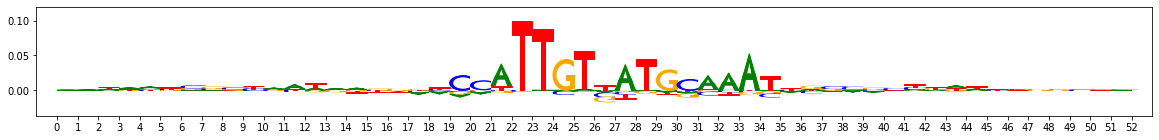

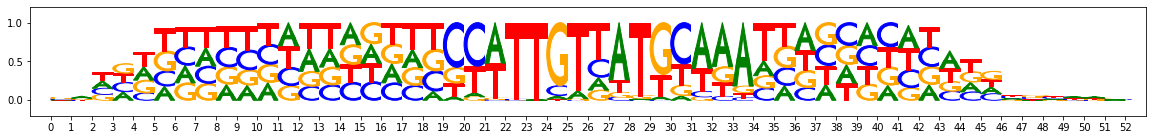

threshpercentile: 8.430232558139535
clusteridx 1 size 237
frac retained 0.9620253164556962


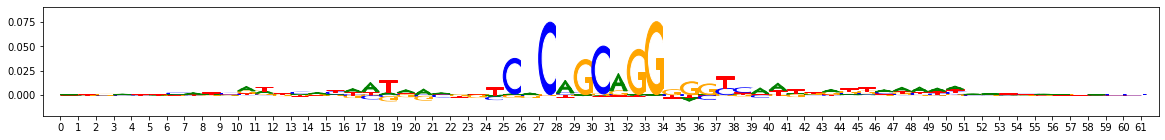

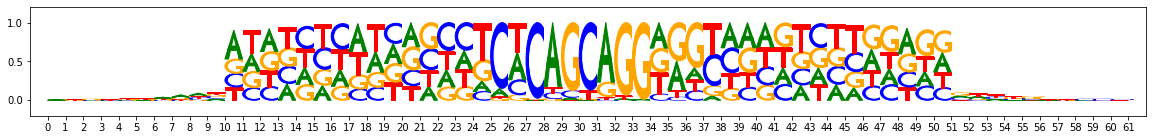

threshpercentile: 2.631578947368421
clusteridx 2 size 225
frac retained 0.7822222222222223
clusteridx 3 size 198
frac retained 0.9949494949494949


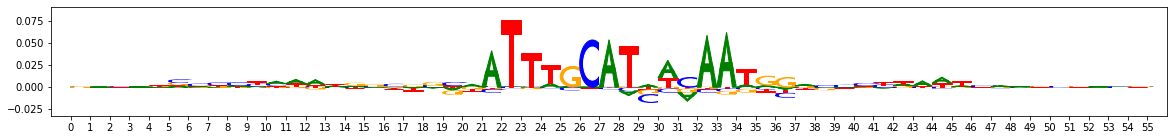

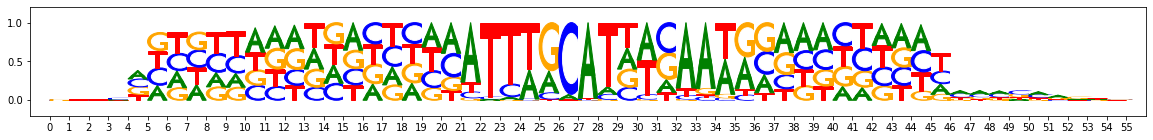

threshpercentile: 10.65989847715736
clusteridx 4 size 186
frac retained 0.7956989247311828
clusteridx 5 size 184
frac retained 0.7282608695652174
clusteridx 6 size 182
frac retained 0.8901098901098901


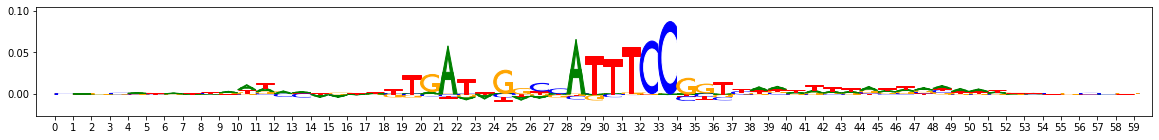

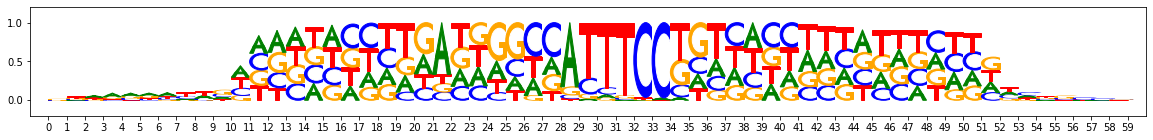

threshpercentile: 5.555555555555555
clusteridx 7 size 133
frac retained 0.5112781954887218
clusteridx 8 size 107
frac retained 0.6915887850467289
clusteridx 9 size 106
frac retained 0.6226415094339622
clusteridx 10 size 104
frac retained 0.7403846153846154
clusteridx 11 size 96
frac retained 0.7916666666666666
clusteridx 12 size 92
frac retained 0.6304347826086957
clusteridx 13 size 90
frac retained 0.8111111111111111


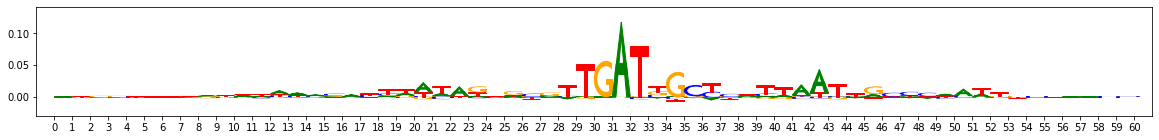

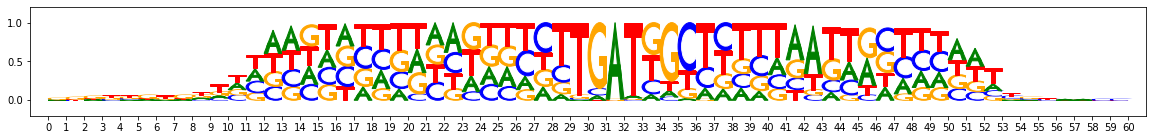

threshpercentile: 9.58904109589041
clusteridx 14 size 86
frac retained 0.8953488372093024


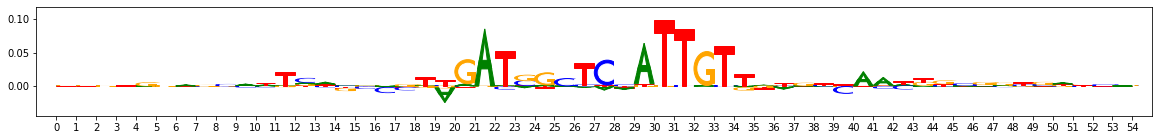

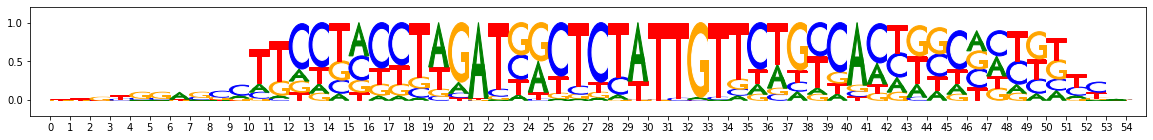

threshpercentile: 7.792207792207792
clusteridx 15 size 86
frac retained 0.7674418604651163
clusteridx 16 size 85
frac retained 0.7529411764705882
clusteridx 17 size 83
frac retained 0.7469879518072289
clusteridx 18 size 81
frac retained 0.8024691358024691


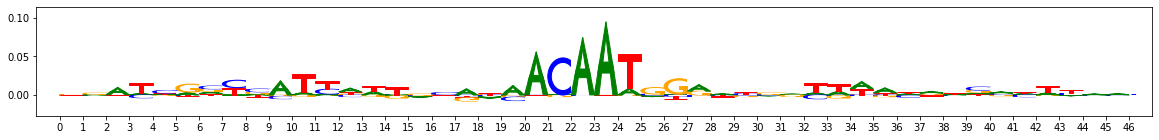

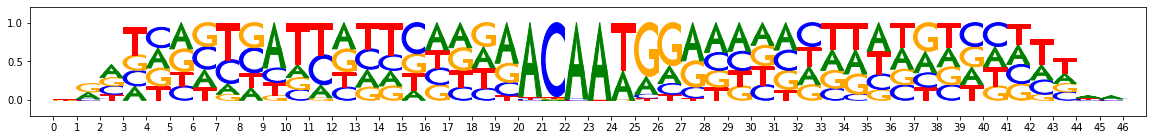

threshpercentile: 18.461538461538463
clusteridx 19 size 79
frac retained 0.9620253164556962


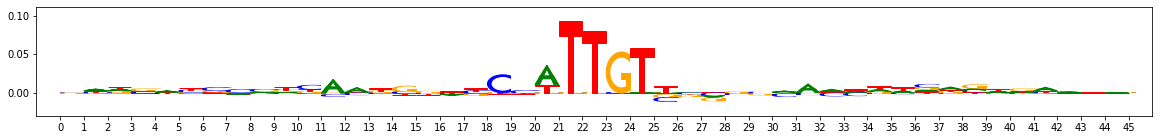

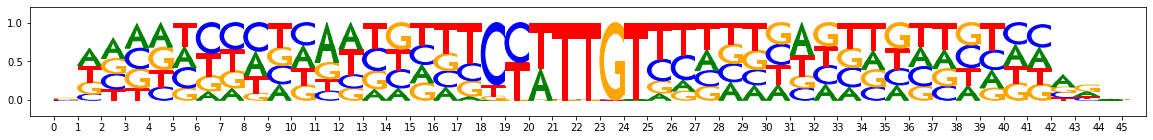

threshpercentile: 15.789473684210526
clusteridx 20 size 78
frac retained 0.7435897435897436
clusteridx 21 size 74
frac retained 0.6891891891891891
clusteridx 22 size 70
frac retained 0.9


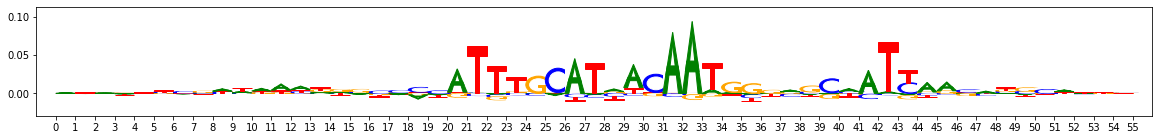

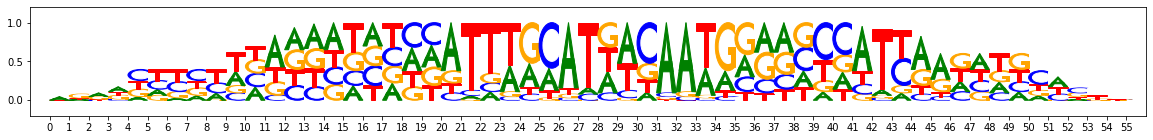

threshpercentile: 14.285714285714285
clusteridx 23 size 68
frac retained 0.8970588235294118


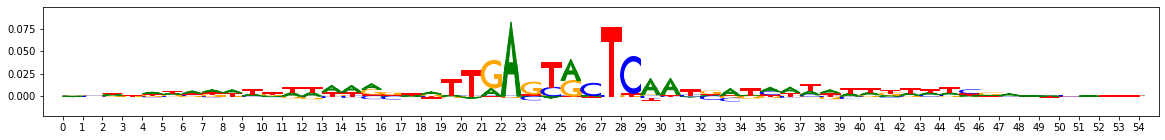

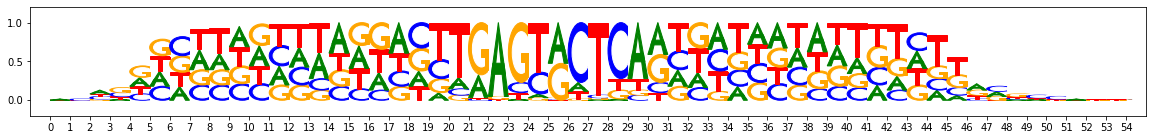

threshpercentile: 13.114754098360656
clusteridx 24 size 66
frac retained 0.5909090909090909
clusteridx 25 size 55
frac retained 0.6
clusteridx 26 size 54
frac retained 0.6111111111111112
clusteridx 27 size 53
frac retained 1.0


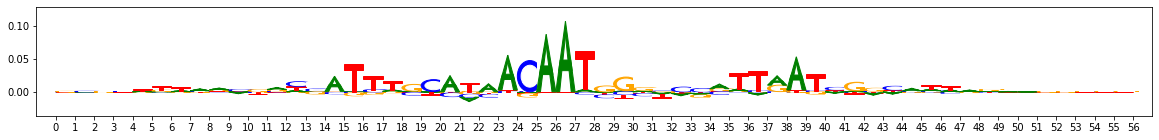

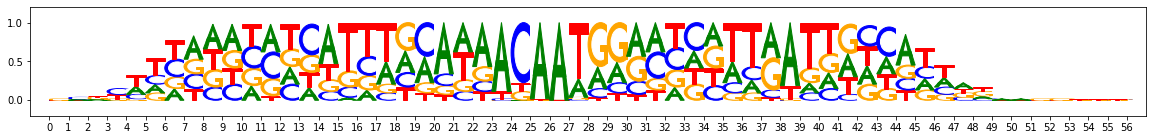

threshpercentile: 15.09433962264151
clusteridx 28 size 53
frac retained 0.7358490566037735
clusteridx 29 size 48
frac retained 0.9375


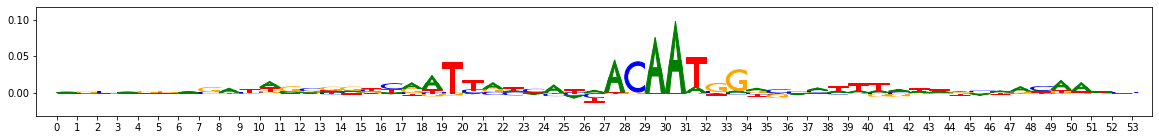

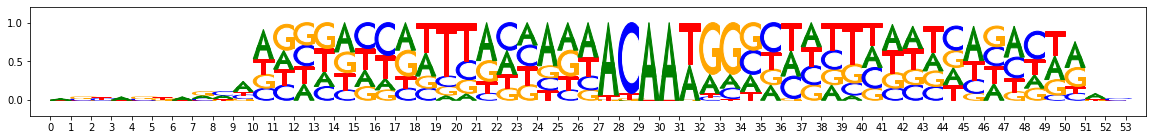

threshpercentile: 15.555555555555555
clusteridx 30 size 48
frac retained 0.8333333333333334


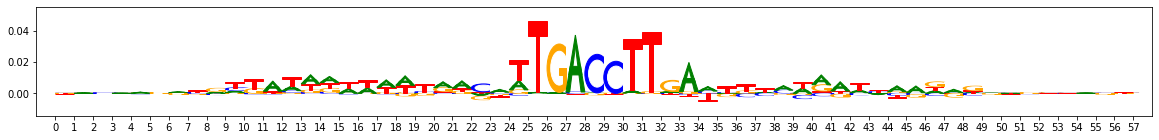

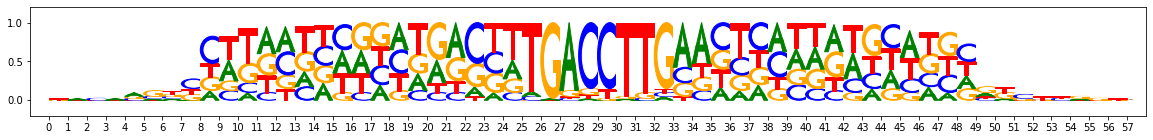

threshpercentile: 7.5
clusteridx 31 size 46
frac retained 0.6521739130434783
clusteridx 32 size 46
frac retained 0.9565217391304348


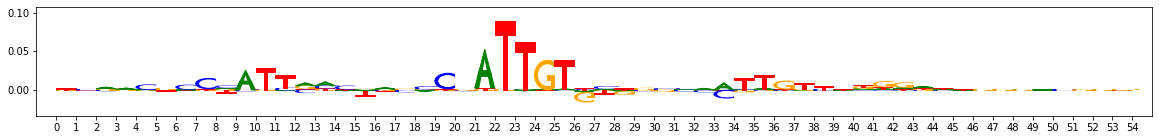

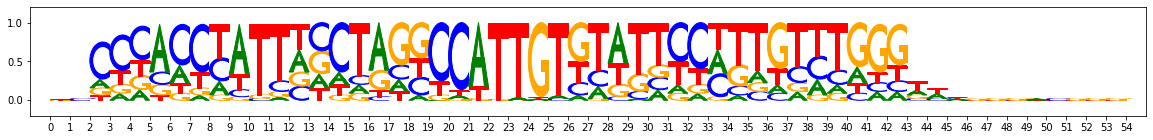

threshpercentile: 11.363636363636363
clusteridx 33 size 44
frac retained 1.0


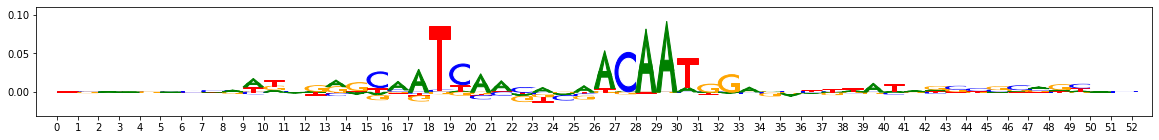

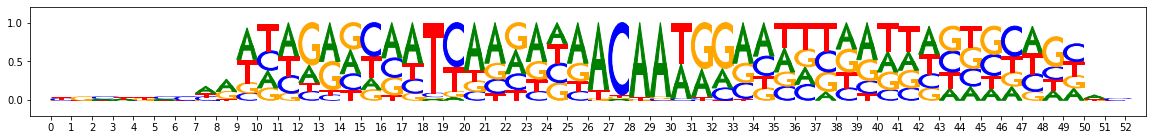

threshpercentile: 11.363636363636363
clusteridx 34 size 43
frac retained 0.3953488372093023
clusteridx 35 size 42
frac retained 0.9285714285714286


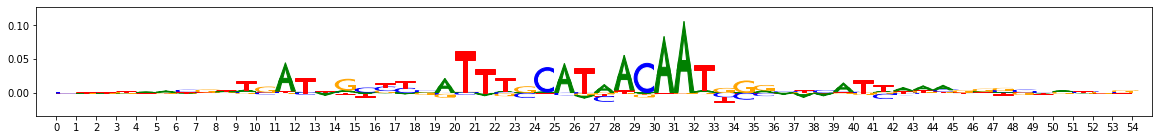

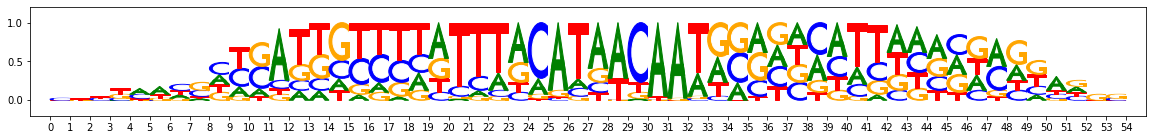

threshpercentile: 10.256410256410255
clusteridx 36 size 41
frac retained 0.5365853658536586
clusteridx 37 size 40
frac retained 0.275
clusteridx 38 size 40
frac retained 0.325
clusteridx 39 size 39
frac retained 0.5897435897435898
clusteridx 40 size 38
frac retained 0.34210526315789475
clusteridx 41 size 36
frac retained 1.0


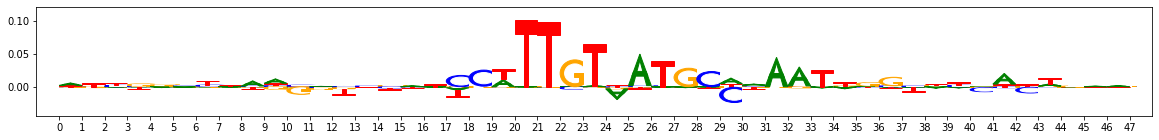

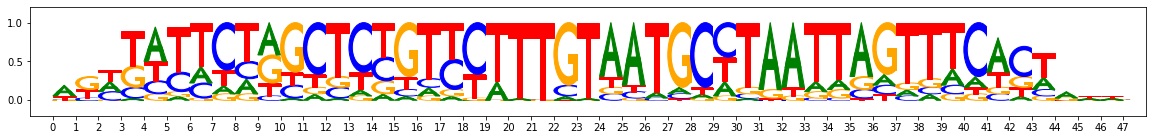

threshpercentile: 13.88888888888889
clusteridx 42 size 34
frac retained 0.35294117647058826
clusteridx 43 size 33
frac retained 0.5757575757575758
clusteridx 44 size 31
frac retained 1.0


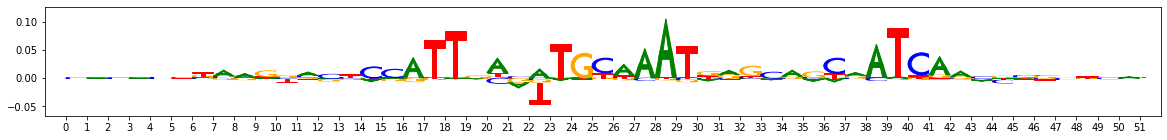

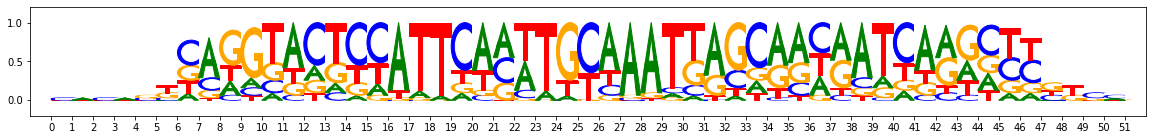

threshpercentile: 9.67741935483871
clusteridx 45 size 31
frac retained 0.9032258064516129


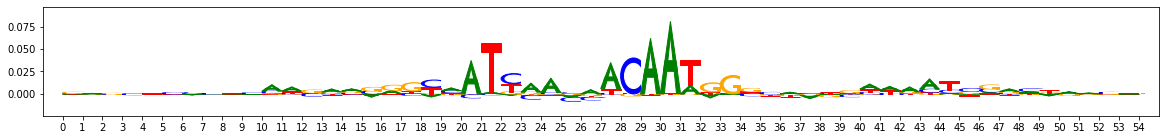

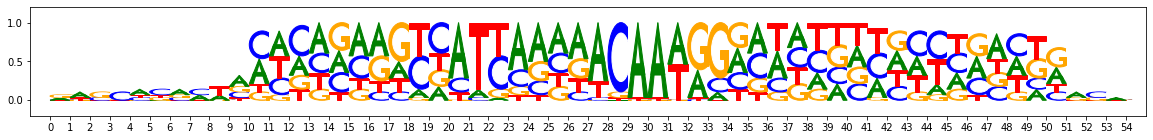

threshpercentile: 7.142857142857142
clusteridx 46 size 30
frac retained 0.43333333333333335
clusteridx 47 size 30
frac retained 0.6
clusteridx 48 size 29
frac retained 0.8620689655172413


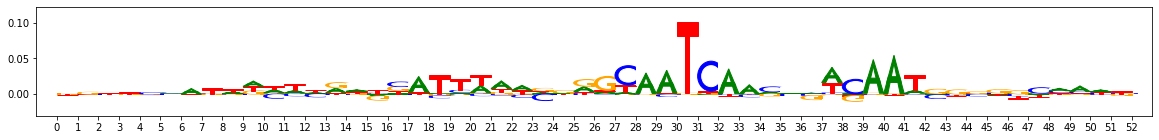

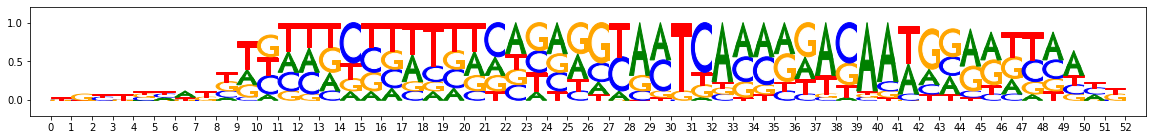

threshpercentile: 12.0
clusteridx 49 size 28
frac retained 0.9642857142857143


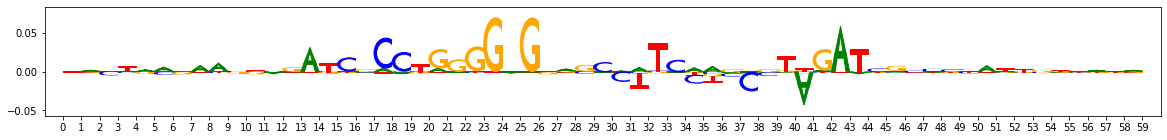

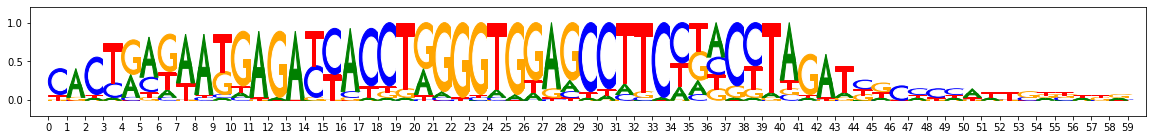

threshpercentile: 3.7037037037037033
clusteridx 50 size 28
frac retained 0.9285714285714286


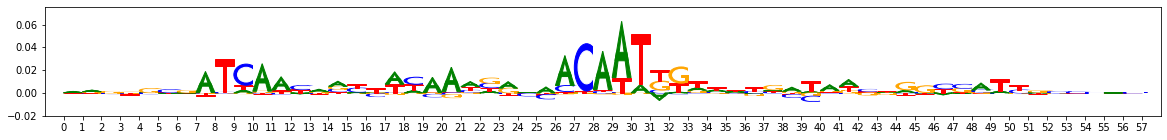

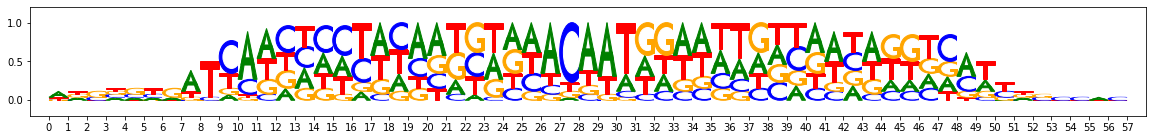

threshpercentile: 15.384615384615385
clusteridx 51 size 26
frac retained 0.9230769230769231


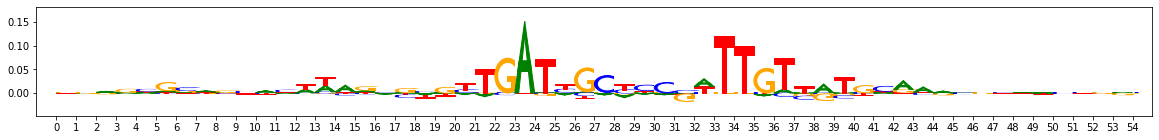

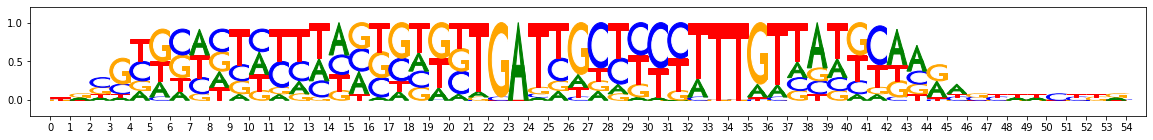

threshpercentile: 4.166666666666666
clusteridx 52 size 26
frac retained 0.9230769230769231


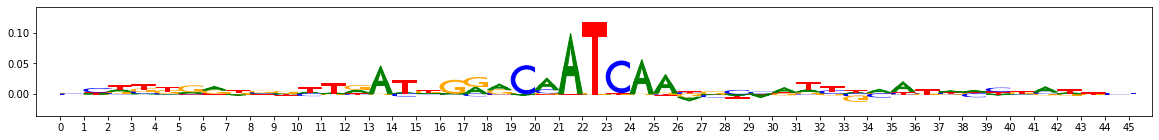

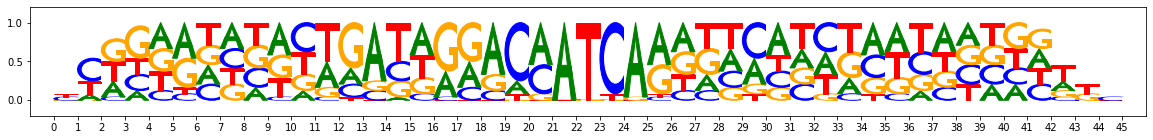

threshpercentile: 16.666666666666664
clusteridx 53 size 25
frac retained 0.2
clusteridx 54 size 24
frac retained 0.6666666666666666
clusteridx 55 size 23
frac retained 0.782608695652174
clusteridx 56 size 22
frac retained 0.8636363636363636
clusteridx 57 size 22
frac retained 0.9545454545454546


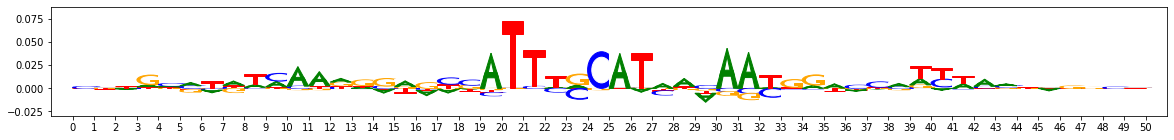

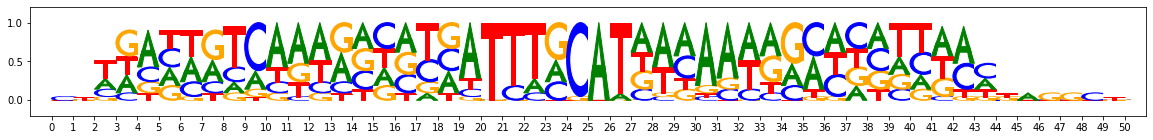

threshpercentile: 14.285714285714285
clusteridx 58 size 21
frac retained 0.6666666666666666
clusteridx 59 size 21
frac retained 0.5238095238095238
clusteridx 60 size 21
frac retained 0.7142857142857143


In [325]:
#for each cluster...
seqletimps = np.array([np.sum(x["contrib_scores"].corefwd) for x in seqlets_subsample])

min_cluster_size = 20
seqlets_per_exemplar = 20

distmat_for_exemplars = np.log(1.0/(np.maximum(affmat,1e-7)))
zerodiagaffmat = affmat*(1-np.eye(affmat.shape[0]))
clusteridx_to_refinedinclustermask = {}
clusteridx_to_exemplarindices = {}
clusteridx_to_arrayforcomputingpercentile = {}
for clusteridx in range(max(the_clustering)+1):
    unrefined_in_cluster_mask = clusteridx==the_clustering
    
    aggregated_seqlet = get_aggregated_seqlet(
        seqlets=seqlets_subsample, in_cluster_mask=unrefined_in_cluster_mask,
        distmat=distmat_for_exemplars, isfwdmat=isfwdmat, offsets=offsets)
    
    if (sum(unrefined_in_cluster_mask) > min_cluster_size):
        
        print("clusteridx",clusteridx,"size",sum(unrefined_in_cluster_mask))
        
        #viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].fwd)
        #viz_sequence.plot_weights(aggregated_seqlet["onehot"].fwd)
        
        median_within_to_within = np.median(affmat[unrefined_in_cluster_mask][:,unrefined_in_cluster_mask],axis=-1)
        median_within_to_out = np.median(affmat[unrefined_in_cluster_mask][:,unrefined_in_cluster_mask==False],axis=-1)
        
        #discard any seqlets where the median similarity to the outside exceeds the median sim to the inside
        #sort the seqlets by their similarity within the cluster, then march down the list until
        # we get into the situation where the min median similarity of some seqlet to within the cluster is less than
        # the max median similarity of some seqlet to outside the cluster.
        #Only retain the set of seqlets such that the min median similarity within the cluster exceeds
        # the max median similarity outside the cluster
        argsort_median_within_to_within = np.argsort(median_within_to_within)[::-1]
        sorted_median_within_to_within = median_within_to_within[argsort_median_within_to_within]
        sorted_median_within_to_out = median_within_to_out[argsort_median_within_to_within]
        runningmin_sorted_median_within_to_within = np.minimum.accumulate(sorted_median_within_to_within)
        runningmax_sorted_median_within_to_out = np.maximum.accumulate(sorted_median_within_to_out)
        
        #rel_indices_to_retain are indices in argsort_median_within_to_within, which are in turn
        # relative to whatever is in the cluster
        rel_indices_to_retain = argsort_median_within_to_within[0:
                                 [x[0] for x in enumerate((runningmin_sorted_median_within_to_within
                                                           -runningmax_sorted_median_within_to_out))
                                  if x[1] > 0][-1]+1]
        #convert rel_indices_to_retain to a boolean mask
        tmp = np.zeros(len((median_within_to_within)), dtype="bool")
        tmp[rel_indices_to_retain] = True
        rel_retainmask = tmp
        del tmp        
        #create a refined_in_cluster_mask that can be applied over all seqlets to get
        # the subset of seqlets still in the cluster after the filtering
        tmp = np.array(unrefined_in_cluster_mask)
        tmp[unrefined_in_cluster_mask] = rel_retainmask
        refined_in_cluster_mask = tmp
        del tmp    
        frac_retained = np.sum(refined_in_cluster_mask)/np.sum(unrefined_in_cluster_mask)
        print("frac retained", frac_retained)
        
        if (sum(refined_in_cluster_mask) > min_cluster_size and frac_retained > 0.8):
            
            """plt.hist(median_within_to_within, density=True, bins=20, alpha=0.5)
            plt.hist(median_within_to_out, density=True, bins=20, alpha=0.5)
            plt.title("Median within-to-within, median within-to-out")
            plt.show()"""
            
            #plot what it looks like after the filtering...
            pruned_aggregated_seqlet = get_aggregated_seqlet(
                                    seqlets=seqlets_subsample, in_cluster_mask=refined_in_cluster_mask,
                                    distmat=distmat_for_exemplars, isfwdmat=isfwdmat, offsets=offsets)
            viz_sequence.plot_weights(pruned_aggregated_seqlet["contrib_scores"].fwd)
            viz_sequence.plot_weights(pruned_aggregated_seqlet["onehot"].fwd)
            
            clusteridx_to_refinedinclustermask[clusteridx] = refined_in_cluster_mask
            indices_within_cluster = np.arange(len(refined_in_cluster_mask))[refined_in_cluster_mask]

            num_exemplars_for_cluster = int(np.ceil(sum(refined_in_cluster_mask)/seqlets_per_exemplar))
            #use the distmat to pick exemplars...exponentially downweight far-away things
            rel_exemplar_indices = modisco.util.facility_locator(distmat=distmat_for_exemplars[refined_in_cluster_mask][:,refined_in_cluster_mask],
                                                                 num_exemplars=num_exemplars_for_cluster)
            abs_exemplar_indices = indices_within_cluster[rel_exemplar_indices]
            clusteridx_to_exemplarindices[clusteridx] = abs_exemplar_indices
            assert np.min(refined_in_cluster_mask[abs_exemplar_indices])==1.0
            
            #figure out the percentiles for the max similarity to the exemplars for the things that are in the cluster
            max_exemplar_sims_withinclust = np.max(zerodiagaffmat[refined_in_cluster_mask][:,abs_exemplar_indices],axis=-1)
            max_exemplar_sims_outclust = np.max(zerodiagaffmat[refined_in_cluster_mask==False][:,abs_exemplar_indices],axis=-1)
            
            #determine a threshold as
            # - a point where the density to the left of withincluster = density to the right of outerclust AND
            # - point must be >= some threshold (to filter out poor quality clusters)
            #(probably worth printing what the threshold is)
            sorted_max_exemplar_sims_outclust = sorted(max_exemplar_sims_outclust)
            sorted_max_exemplar_sims_withinclust = sorted(max_exemplar_sims_withinclust)
            for i,potential_thresh in enumerate(sorted_max_exemplar_sims_withinclust):
                withinclust_cdf = i/len(sorted_max_exemplar_sims_withinclust)
                outclust_cdf = (np.searchsorted(a=sorted_max_exemplar_sims_outclust, v=potential_thresh)/
                                len(sorted_max_exemplar_sims_outclust))
                if (withinclust_cdf >= (1-outclust_cdf)):
                    selected_thresh = potential_thresh
                    selected_thresh_withinclustcdf = withinclust_cdf
                    break
            print("threshpercentile: "+str(selected_thresh_withinclustcdf*100))   
            #plot the histogram for max_exemplar_sims outside to within...
            """plt.hist(max_exemplar_sims_withinclust, bins=20, density=True, alpha=0.5)
            plt.hist(max_exemplar_sims_outclust, bins=20, density=True, alpha=0.5)
            plt.plot([selected_thresh, selected_thresh], [0, 1], color="black")
            plt.title("threshpercentile: "+str(selected_thresh_withinclustcdf*100))
            plt.show()
            ##compare to using ALL points in cluster
            plt.hist(np.max(zerodiagaffmat[refined_in_cluster_mask][:,refined_in_cluster_mask],axis=-1),
                     bins=20, density=True, alpha=0.5)
            plt.hist(np.max(zerodiagaffmat[refined_in_cluster_mask==False][:,refined_in_cluster_mask],axis=-1),
                     bins=20, density=True, alpha=0.5)
            plt.show()"""
            
            if (selected_thresh_withinclustcdf < 0.2):
                #arrayforcomputingpercentile is a sorted array of "max exemplar similarity" for all
                # the examples within the cluster for which the max exemplar sim was over the threshold
                arrayforcomputingpercentile = np.array([x for x in sorted_max_exemplar_sims_withinclust
                                                        if x >= selected_thresh])
                clusteridx_to_arrayforcomputingpercentile[clusteridx] = arrayforcomputingpercentile
                #assert np.searchsorted(a=arrayforcomputingpercentile, v=selected_thresh, side='right')==1



fraction mapping to a cluster: 0.7006
idx 0 size 108


/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


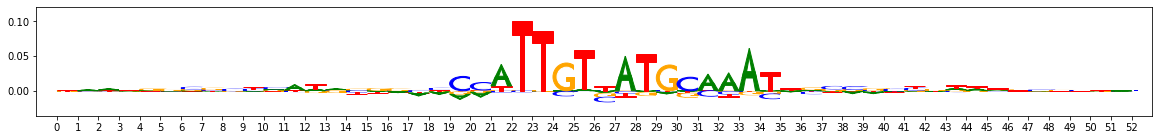

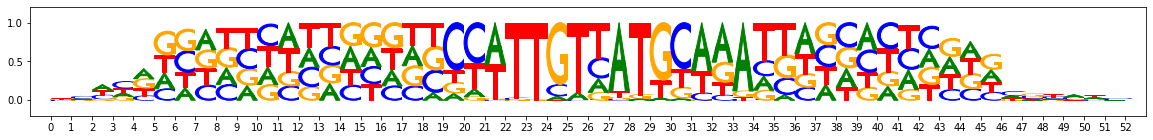

idx 1 size 266


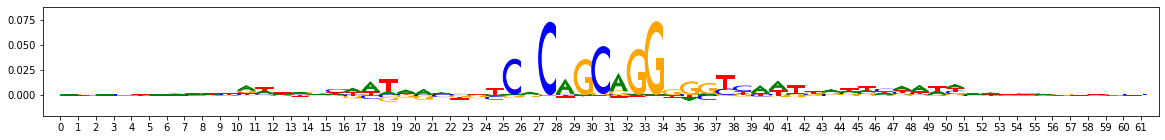

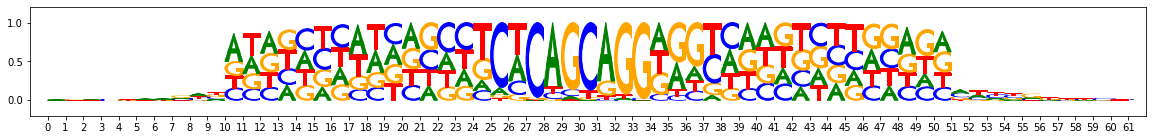

idx 2 size 152


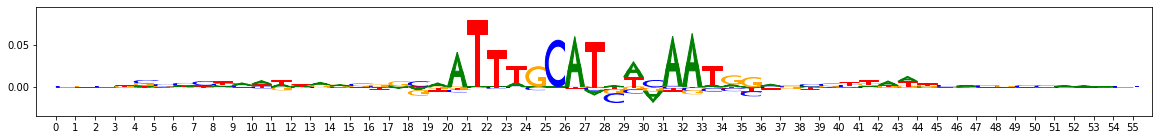

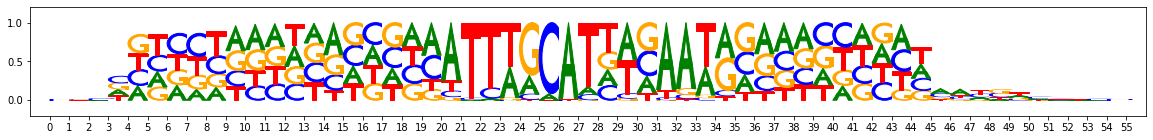

idx 3 size 251


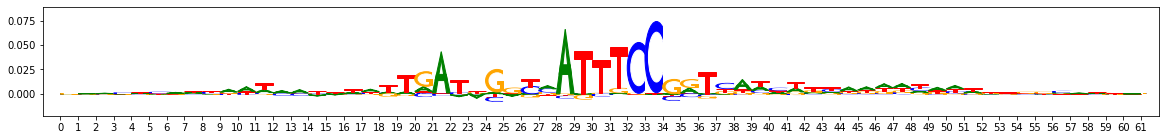

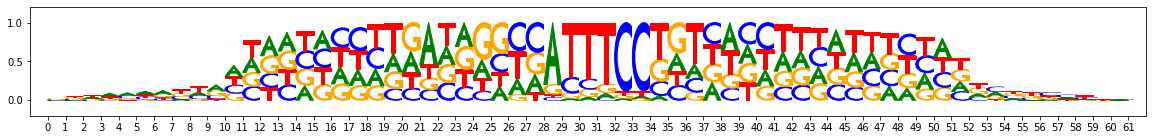

idx 4 size 318


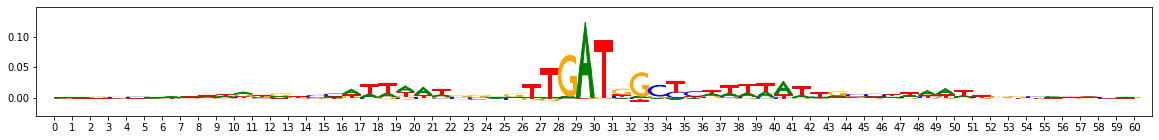

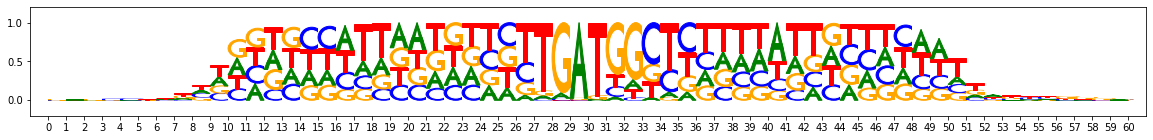

idx 5 size 71


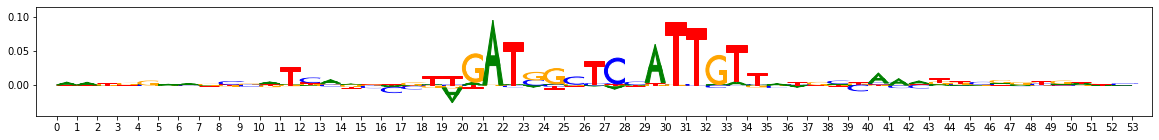

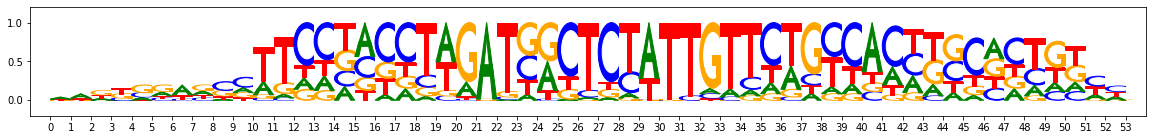

idx 6 size 304


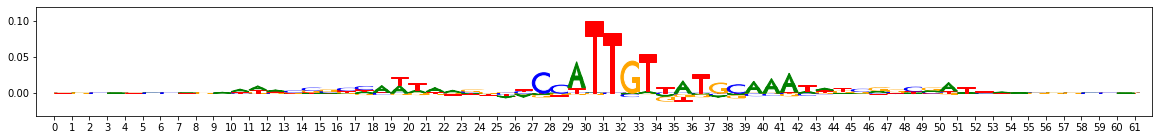

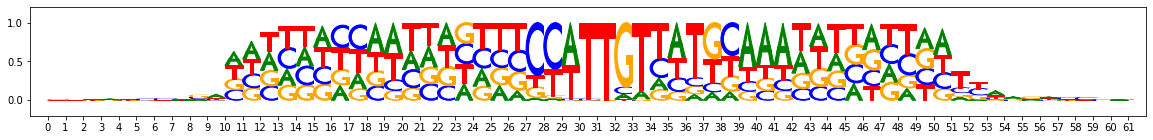

idx 7 size 129


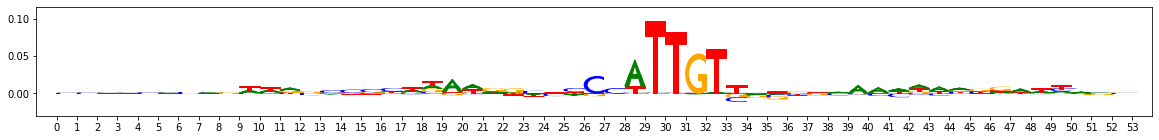

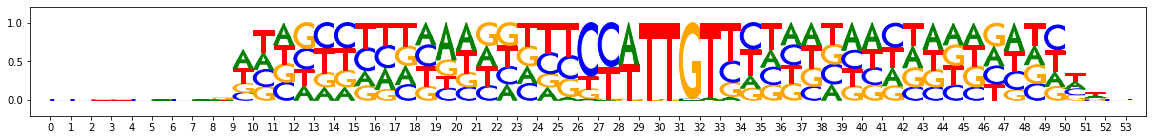

idx 8 size 99


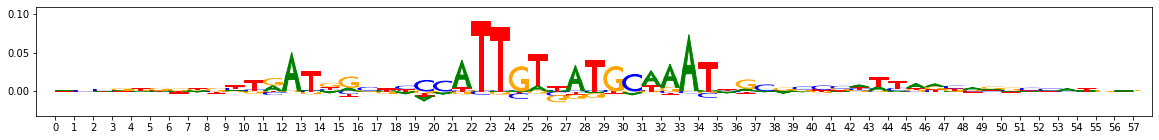

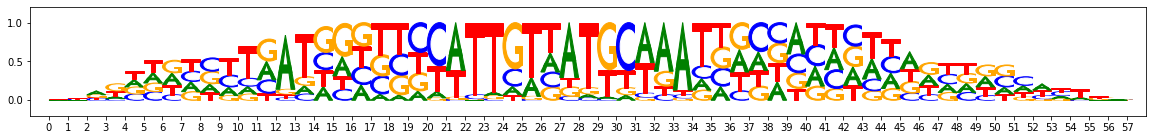

idx 9 size 290


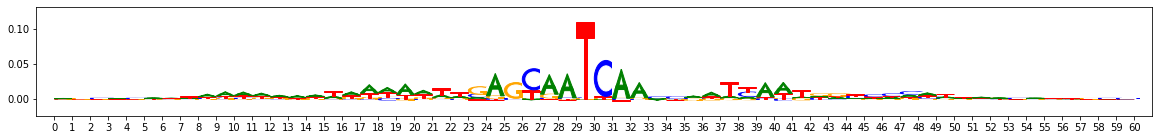

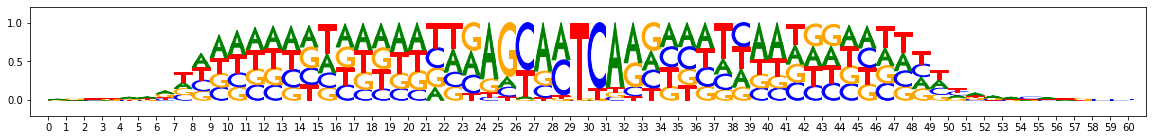

idx 10 size 83


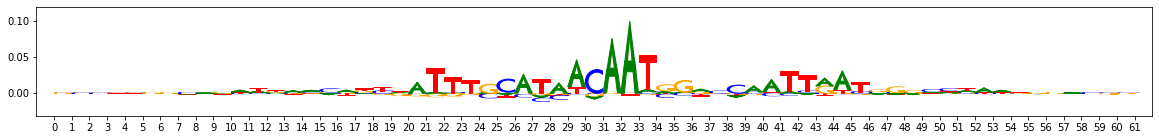

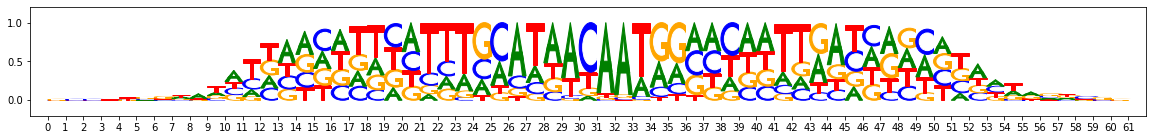

idx 11 size 121


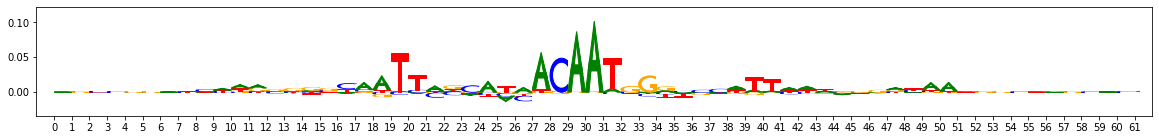

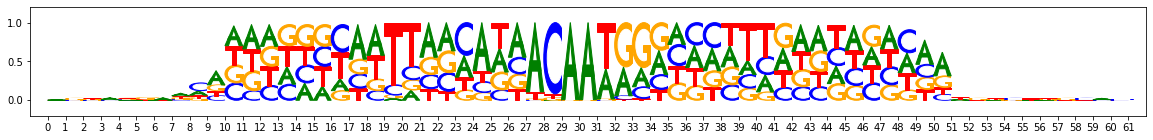

idx 12 size 118


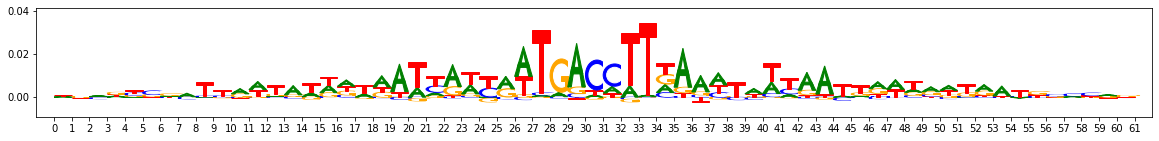

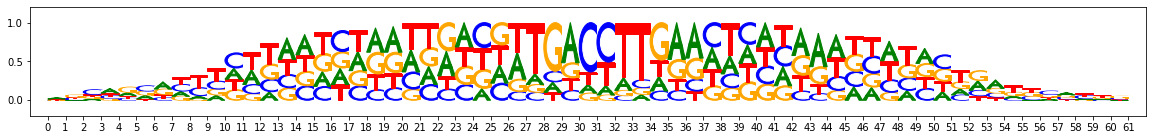

idx 13 size 60


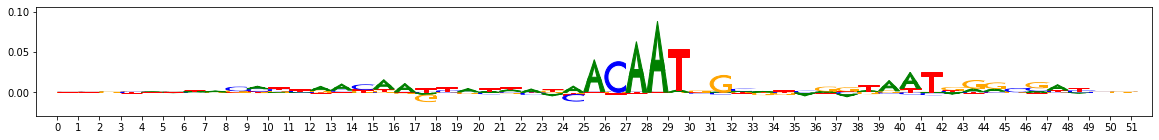

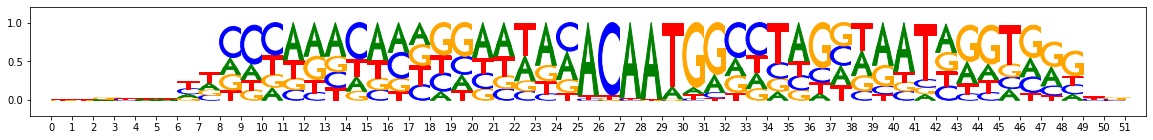

idx 14 size 93


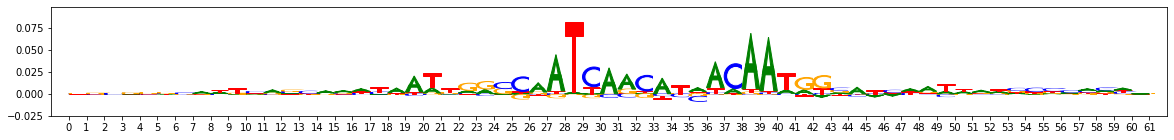

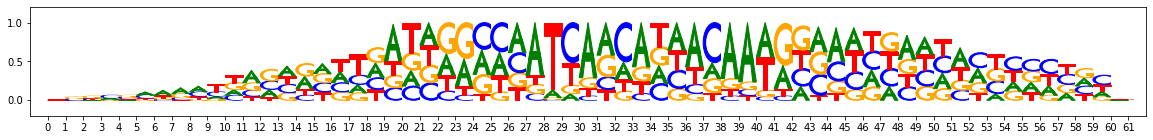

idx 15 size 59


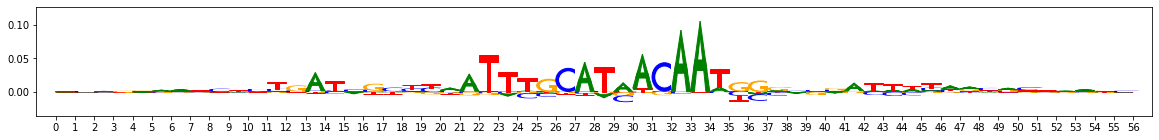

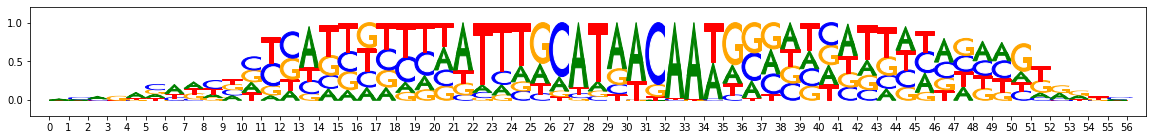

idx 16 size 22


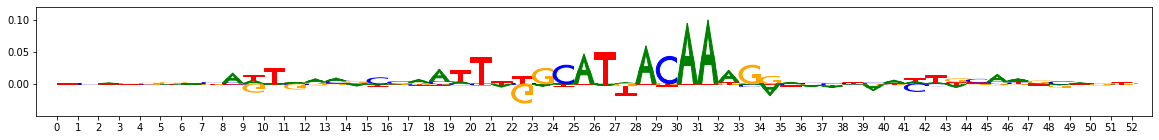

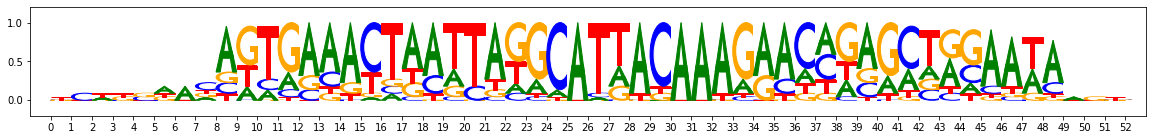

idx 17 size 37


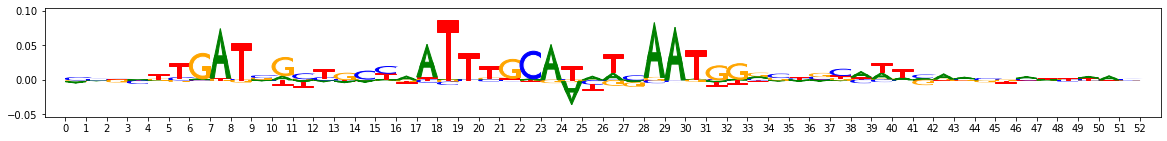

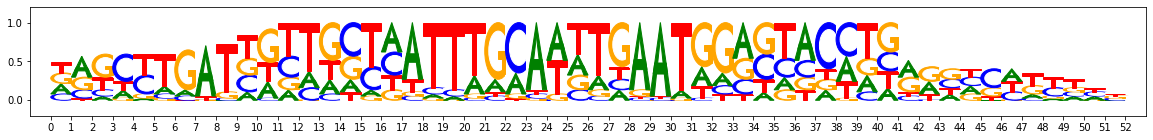

idx 18 size 80


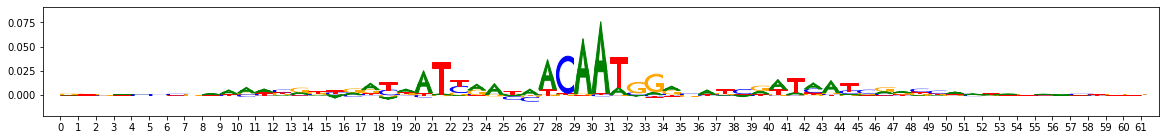

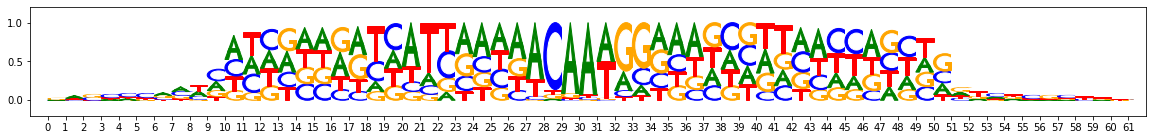

idx 19 size 164


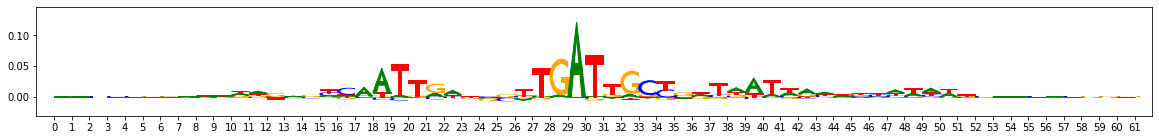

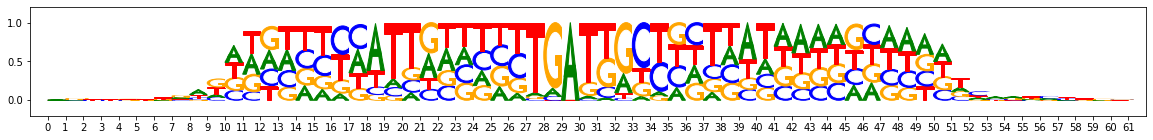

idx 20 size 39


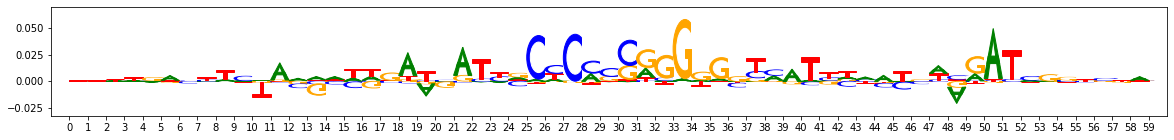

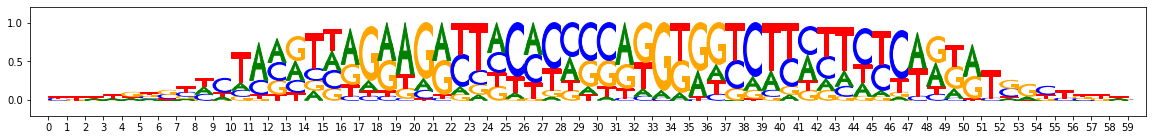

idx 21 size 185


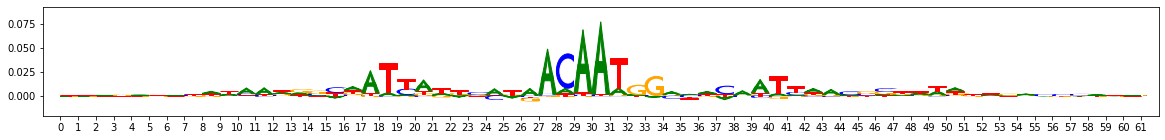

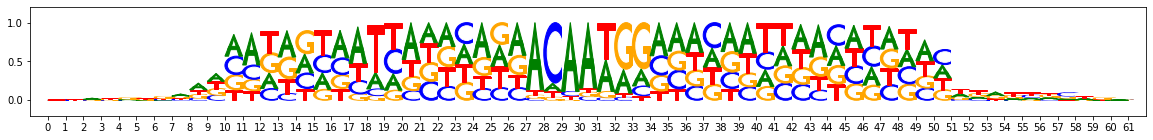

idx 22 size 43


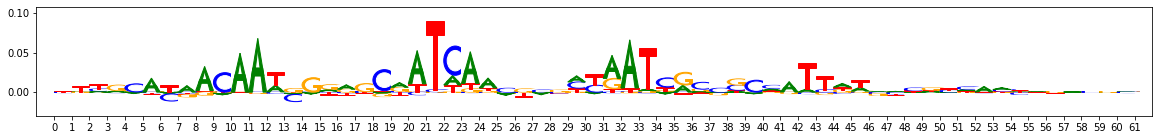

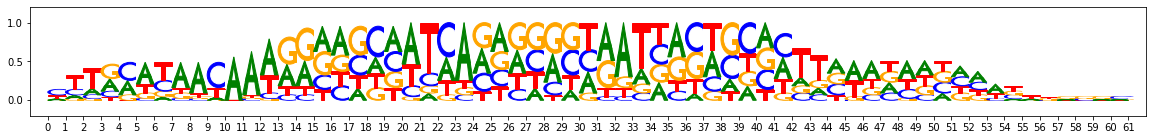

idx 23 size 293


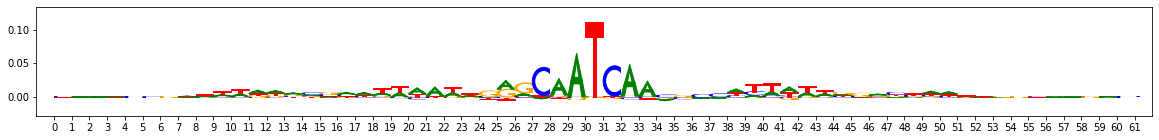

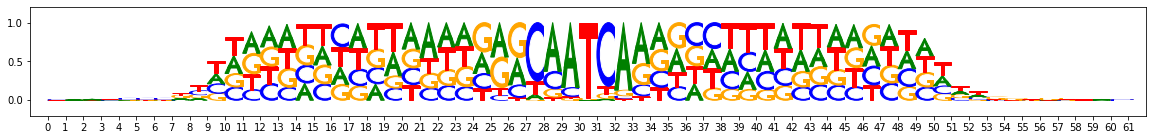

idx 24 size 118


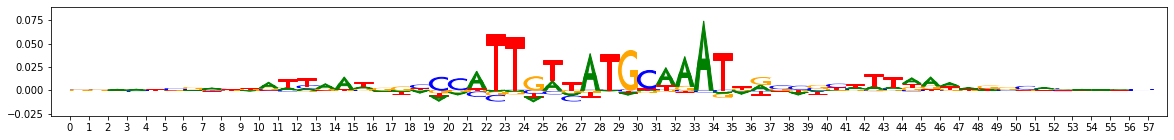

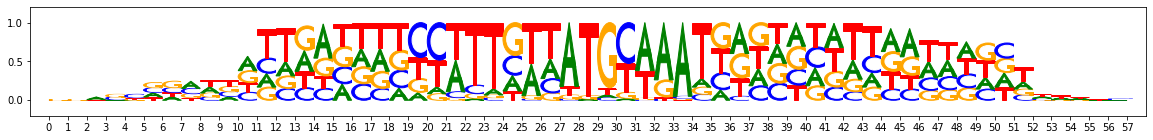

In [326]:

#get clusteridx->seqletpercentiles
clusterremappedidx_to_seqletpercentiles = []
for clusteridx in sorted(clusteridx_to_arrayforcomputingpercentile.keys()):
    exemplarindicesforcluster = clusteridx_to_exemplarindices[clusteridx]
    maxexemplarsims = np.max(affmat[:,exemplarindicesforcluster],axis=-1)
    arrayforcomputingpercentiles = clusteridx_to_arrayforcomputingpercentile[clusteridx]
    seqletpercentiles = (np.searchsorted(a=arrayforcomputingpercentiles,
                                         v=maxexemplarsims, side='right'))/(len(arrayforcomputingpercentiles))
    clusterremappedidx_to_seqletpercentiles.append(seqletpercentiles)

maps_to_a_cluster = (np.max(clusterremappedidx_to_seqletpercentiles, 0))>0
best_cluster_match = np.argmax(clusterremappedidx_to_seqletpercentiles, axis=0)
print("fraction mapping to a cluster:", np.mean(maps_to_a_cluster))
for newclusteridx in range(len(clusterremappedidx_to_seqletpercentiles)):
    in_cluster_mask = (best_cluster_match==newclusteridx)*maps_to_a_cluster
    aggregated_seqlet = get_aggregated_seqlet(
        seqlets=seqlets_subsample, in_cluster_mask=in_cluster_mask,
        distmat=distmat_for_exemplars, isfwdmat=isfwdmat, offsets=offsets)
    print("idx",newclusteridx,"size", sum(in_cluster_mask))
    viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].fwd)
    viz_sequence.plot_weights(aggregated_seqlet["onehot"].fwd)

#display the things mapping to each cluster.

#argmaxcluster = np.argmax(clusterremappedidx_to_seqletpercentiles, 0)
#    
#new_cluster_mapping = []
#for seqletidx in range(len(seqlets_subsample)):
#    forseqlet_clusteridx_to_percentile = {}
    
        
    

#map a seqlet to a cluster if:
# (1) its median exemplar similarity is better than that of [xth percentile] in the cluster AND
# (2) it has the highest percentile of all the clusters it maps to
#[revisit later: repeat until some kind of convergence, hopefully?]
# then use to soak
#...or could also go the SVM route...

#(Have a hypothetical exemplar?)
#hmm...how do I decide that something is not in the cluster - do I need exemplars for the outside?

#other idea: start w/ exemplars, then "grow" them out until stable assignment?
#start w. exemplars, merge based on exemplar sims to other exemplars, once merged, grow.

In [ ]:
reload(modisco.core)
reload(modisco.util)

seqletimps = np.array([np.sum(x["contrib_scores"].corefwd) for x in seqlets_subsample])

min_cluster_support = 20

seqlets_so_far = 0
print("Numbed of clusters:",np.max(the_clustering)+1)
for idx in range(max(the_clustering)+1):
    in_cluster_mask = idx==the_clustering
    num_in_cluster = np.sum(in_cluster_mask)
    seqlets_so_far += num_in_cluster
    print("Coverage:", )
    print("Cluster idx",idx,"size",num_in_cluster)
    if (num_in_cluster > min_cluster_support):
        #find an anchor for the cluster as the one with the minimum total distance to all the others
        #ok this doesn't work that well
        #anchor = np.argmin(np.sum(distmat[:,in_cluster_mask],axis=-1)+((in_cluster_mask==False)*np.inf))
        anchor = np.argmax(seqletimps*in_cluster_mask) #highest imp for anchor - this works better
        #sortinfo = np.argsort(seqletimps[in_cluster_mask])[::-1] #np.argsort(distmat[in_cluster_mask, anchor])
        sortinfo = np.argsort(np.median(distmat[in_cluster_mask][:,in_cluster_mask], axis=-1))
        isfwdinfo = isfwdmat[in_cluster_mask,anchor][sortinfo]
        #offsetsinfo gives the offset w.r.t. the start of anchor
        offsetsinfo = offsets[in_cluster_mask,anchor][sortinfo]
        #get the relative offsets within the cluster
        pairwise_within_cluster_offsets = offsets[in_cluster_mask][:,in_cluster_mask]
        pairwise_within_cluster_isfwdmat = isfwdmat[in_cluster_mask][:,in_cluster_mask]
        predicted_pairwise_within_cluster_offsets = offsetsinfo[None,:] - offsetsinfo[:,None]
        #print(pairwise_within_cluster_offsets)
        #print(predicted_pairwise_within_cluster_offsets)
        #print(pairwise_within_cluster_isfwdmat)
        #print(offsetsinfo)
        
        seqlets_in_cluster_allfwd_unsorted = [seqlet for seqlet,incluster in zip(seqlets_subsample, in_cluster_mask) if incluster]
        seqlets_in_cluster_allfwd = [seqlets_in_cluster_allfwd_unsorted[i] for i in sortinfo]
        oriented_seqlets_in_cluster = [(seqlet if isfwd==True else seqlet.get_revcomp())
                                       for (seqlet, isfwd) in zip(seqlets_in_cluster_allfwd, isfwdinfo)]
        aggregated_seqlet = modisco.core.AggregatedSeqlet(seqlets=oriented_seqlets_in_cluster[:],
                                                          offsets=offsetsinfo[:])
        
        #viz_sequence.plot_weights(aggregated_seqlet["hypcontrib_scores"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["hypcontrib_scores"].fwd
                                  - np.mean(aggregated_seqlet["hypcontrib_scores"].fwd, axis=-1)[:,None])
        viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].fwd)
        viz_sequence.plot_weights(aggregated_seqlet["onehot"].fwd)
        #viz_sequence.plot_weights(aggregated_seqlet["hypcontrib_scores"].rev)
        viz_sequence.plot_weights(aggregated_seqlet["hypcontrib_scores"].rev
                                  - np.mean(aggregated_seqlet["hypcontrib_scores"].rev, axis=-1)[:,None])
        viz_sequence.plot_weights(aggregated_seqlet["contrib_scores"].rev)
        viz_sequence.plot_weights(aggregated_seqlet["onehot"].rev)
        #plot the distribution of pairwise dissimilarities within the cluster
        zerodiagaffmat = affmat*(1-np.eye(affmat.shape[0]))
        print("Pairwise within v pairwise out-to-within")
        plt.hist(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask].ravel(), bins=50, density=True, alpha=0.5)
        plt.hist(zerodiagaffmat[in_cluster_mask==False][:,in_cluster_mask].ravel(), bins=50, density=True, alpha=0.5)
        plt.show()
        print("Median within v median out-to-within")
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask==False][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.show()
        print("Median within, median within-to-out")
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        plt.show()
        print("Max within v max out-to-within")
        plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.hist(np.max(zerodiagaffmat[in_cluster_mask==False][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.show()
        print("Max within v max within-to-out")
        plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)        
        plt.show()
        
        #viz some number
        """print("Visualizing seqlets")
        modisco.util.viz_seqlets_with_offsets(
            seqlets=oriented_seqlets_in_cluster,
            offsets=offsetsinfo, trackname="contrib_scores", num_to_plot=10)
        print("Done visualizing seqlets")"""
        
        #plt.hist(np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1)
        #         - np.median(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        #plt.show()
        #plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1), bins=50, density=True, alpha=0.5)
        #plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        #plt.show()
        #plt.hist(np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask],axis=-1)
        #         - np.max(zerodiagaffmat[in_cluster_mask][:,in_cluster_mask==False],axis=-1), bins=50, density=True, alpha=0.5)
        #plt.show()

In [ ]:
#compare clusters
from modisco.visualization import viz_sequence
cluster1 = 0
cluster2 = 2
incluster1mask = cluster1==the_clustering
incluster2mask = cluster2==the_clustering
zerodiagaffmat = affmat*(1-np.eye(affmat.shape[0]))

cluster1_within = plt.hist(zerodiagaffmat[incluster1mask][:,incluster1mask].ravel(),
                           bins=50, density=True, alpha=0.3)
cluster2_within = plt.hist(zerodiagaffmat[incluster2mask][:,incluster2mask].ravel(),
                           bins=50, density=True, alpha=0.3)
cluster12_between = plt.hist(zerodiagaffmat[incluster1mask][:,incluster2mask].ravel(),
                             bins=50, density=True, alpha=0.3)
cluster12_allelse = plt.hist(zerodiagaffmat[(incluster1mask+incluster2mask > 0)][:,(incluster1mask+incluster2mask)==0].ravel(),
                             bins=50, density=True, alpha=0.3)
plt.show()

cluster1_within = plt.hist(np.median(zerodiagaffmat[incluster1mask][:,incluster1mask],axis=-1),
                           bins=50, density=True, alpha=0.3)
cluster2_within = plt.hist(np.median(zerodiagaffmat[incluster2mask][:,incluster2mask],axis=-1),
                           bins=50, density=True, alpha=0.3)
cluster12_between = plt.hist(np.median(zerodiagaffmat[incluster1mask][:,incluster2mask],axis=-1),
                             bins=50, density=True, alpha=0.3)
cluster12_allelse = plt.hist(np.median(zerodiagaffmat[(incluster1mask+incluster2mask > 0)][:,(incluster1mask+incluster2mask)==0],axis=-1),
                             bins=50, density=True, alpha=0.3)
plt.show()

#find an example with very high within-cluster similarity but high dissim to the other cluster
cluster1typical = np.argmax(np.median(zerodiagaffmat[:,incluster1mask],axis=-1) - np.median(zerodiagaffmat[:,incluster2mask],axis=-1))
print(cluster1typical)
viz_sequence.plot_weights(seqlets_subsample[cluster1typical]["contrib_scores"].get_core_with_flank(left=10, right=10, is_revcomp=False))
viz_sequence.plot_weights(seqlets_subsample[cluster1typical]["hypcontrib_scores"].get_core_with_flank(left=10, right=10, is_revcomp=False))

#find an example with very high within-cluster similarity but high dissim to the other cluster
cluster2typical = np.argmax(np.median(zerodiagaffmat[:,incluster2mask],axis=-1) - np.median(zerodiagaffmat[:,incluster1mask],axis=-1))
print(cluster2typical)
viz_sequence.plot_weights(seqlets_subsample[cluster2typical]["contrib_scores"].get_core_with_flank(left=10, right=10, is_revcomp=False))
viz_sequence.plot_weights(seqlets_subsample[cluster2typical]["hypcontrib_scores"].get_core_with_flank(left=10, right=10, is_revcomp=False))